In [79]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
df = pd.read_csv('../data/bikes_rent.csv')
df.sample(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
204,3,0,7,0,0,0,1,34.030000,39.74145,55.0833,11.334457,5.066811,3606
106,2,0,4,0,0,0,1,18.723347,22.28480,47.9583,20.334232,9.089956,3744
253,3,0,9,0,0,0,1,26.786653,30.46145,71.3750,7.708618,3.445962,5046
208,3,0,7,0,4,1,1,31.945847,36.99500,58.3333,11.958093,5.345594,4390
539,3,1,6,0,6,0,1,29.998347,32.63960,53.4583,12.041307,5.382793,7458


In [3]:
df.isnull().sum()

season            0
yr                0
mnth              0
holiday           0
weekday           0
workingday        0
weathersit        0
temp              0
atemp             0
hum               0
windspeed(mph)    0
windspeed(ms)     0
cnt               0
dtype: int64

In [4]:
target = ['cnt']
numeric_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']
categorial_features = [col for col in df.columns[:-1] if col not in numeric_features + target]

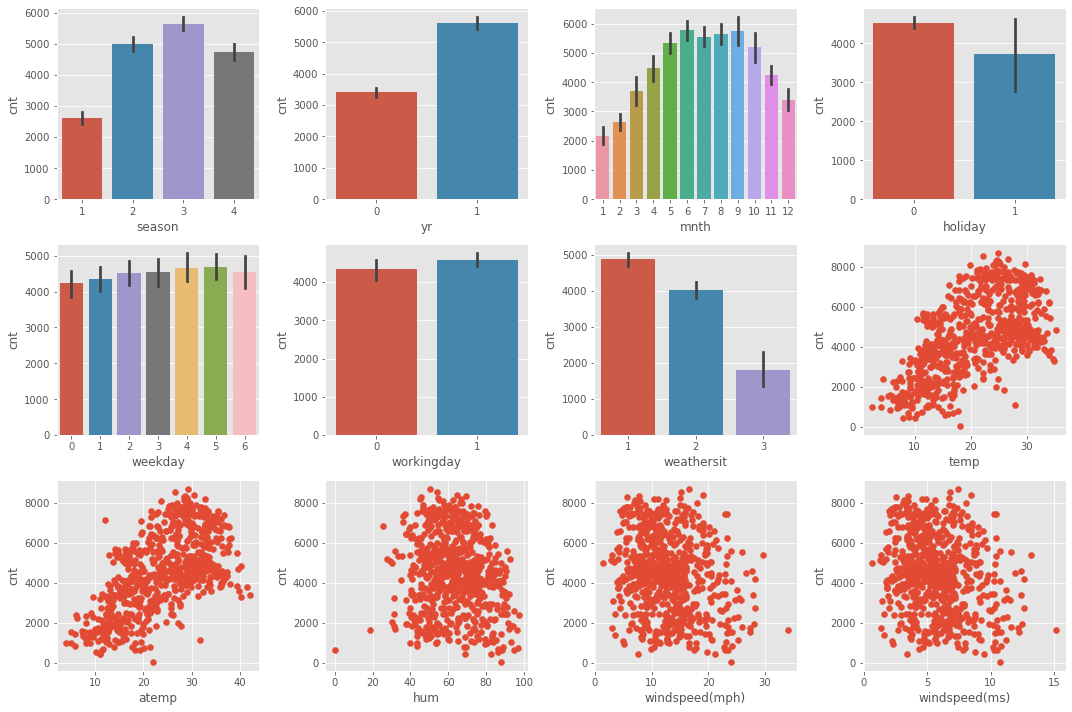

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    #df.plot(feature, 'cnt', subplots=True, kind='scatter', ax=axes[int(idx / 4), idx % 4])
    if feature in numeric_features:
        plt.subplot(3, 4, idx+1)
        plt.scatter(x=df.loc[:, feature], y=df.loc[:, 'cnt'])
        plt.ylabel('cnt')
        plt.xlabel(feature)
    else:
        plt.subplot(3, 4, idx+1)
        sns.barplot(x=df.loc[:, feature], y=df.loc[:, 'cnt'])
fig.tight_layout()
plt.show()

In [25]:
df[categorial_features[0]].value_counts()


3    188
2    184
1    181
4    178
Name: season, dtype: int64

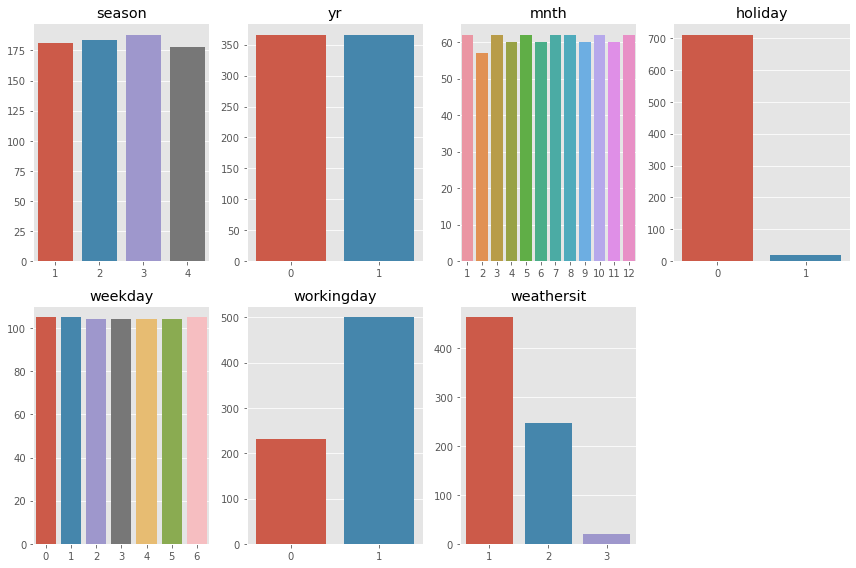

In [26]:
plt.figure()
for idx, feature in enumerate(categorial_features):
    plt.subplot(2, 4, idx+1)
    temp = df[feature].value_counts()
    sns.barplot(x=temp.index, y=temp.values)
    plt.title(feature)
plt.tight_layout()
plt.show()

In [59]:
"""функция дублирует строки, которые содержат малопредставленный класс признака"""
def NewRowsCreaterBinaryFeature(data, feature):
    temp_frame = data.copy()
    if temp_frame[feature].drop_duplicates().shape[0] == 2:
        new_rows_feature_class = temp_frame[feature].value_counts().sort_values().index[0]
        new_rows_number = abs(temp_frame[feature].value_counts().sort_values().values[0] - \
                              temp_frame[feature].value_counts().sort_values().values[1])
        old_rows = temp_frame[temp_frame[feature] == new_rows_feature_class][feature].index.values
        random_indexes = np.random.randint(low=0, high=old_rows.shape[0], size=new_rows_number)
        new_rows_indexes = old_rows[random_indexes]
        temp_frame = pd.concat([temp_frame, temp_frame.loc[new_rows_indexes, :]], axis=0)
        return temp_frame
    else:
        print ('Не бинарный признак')

NewRowsCreaterBinaryFeature(df, 'holiday')

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,2,0,5,1,1,0,1,30.066653,33.55460,68.5000,8.792075,3.930297,4098
724,1,1,12,1,2,0,2,11.943464,14.72325,73.4783,11.304642,5.053483,1013
681,4,1,11,1,1,0,1,19.885000,23.76915,74.1667,11.625639,5.196978,6269
550,3,1,7,1,3,0,1,32.355847,36.61685,53.8750,9.041650,4.041864,7403


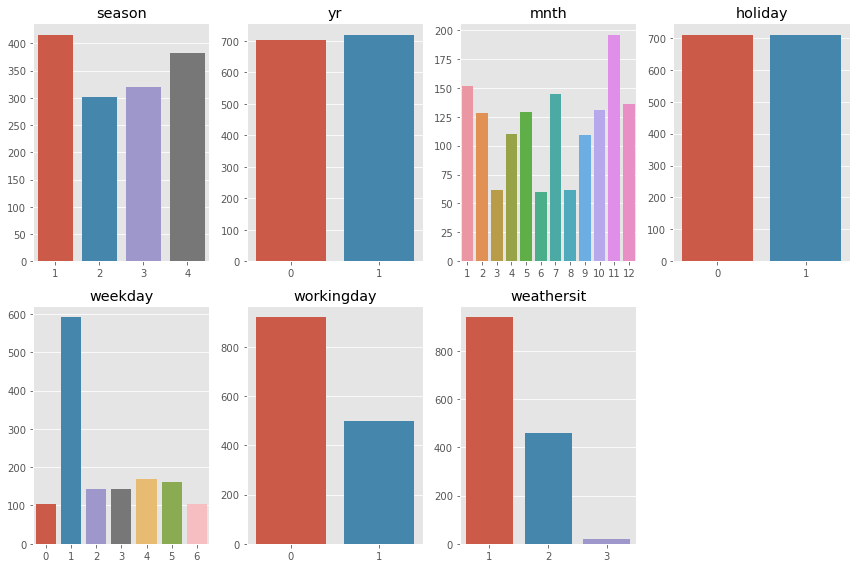

'балансировать классы не получается'

In [64]:
temp = NewRowsCreaterBinaryFeature(df, 'holiday')
plt.figure()
for idx, feature in enumerate(categorial_features):
    plt.subplot(2, 4, idx+1)
    temp_1 = temp[feature].value_counts()
    sns.barplot(x=temp_1.index, y=temp_1.values)
    plt.title(feature)
plt.tight_layout()
plt.show()
del temp
"""балансировать классы не получается"""

In [67]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False)
X_numeric_scaled = pd.DataFrame(data=scaler.fit_transform(df[numeric_features]), index=df.index, columns=numeric_features)
X_cat_encoded = pd.DataFrame(data=encoder.fit_transform(df[categorial_features]), index=df.index)
df_new = pd.concat([X_numeric_scaled, X_cat_encoded], axis=1) 

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_new, df[target], test_size=0.3, shuffle=True)

In [76]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
KFold_cv = KFold(n_splits=3)
alphas = np.arange(1, 400, 1)
lasso_cv_reg_model = LassoCV(cv=KFold(n_splits=3), alphas=alphas)

In [78]:
lasso_cv_reg_model.fit(X_train, y_train)
mean_squared_error(y_test, lasso_cv_reg_model.predict(X_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


668967.7233757848

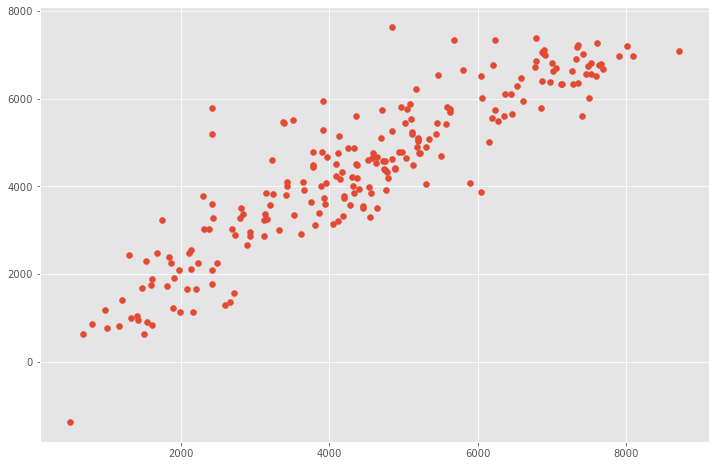

In [89]:
plt.scatter(x=y_test, y=lasso_cv_reg_model.predict(X_test))

In [65]:
from sklearn.metrics import mean_squared_error
for model in [lin_reg_model, lasso_reg_model, ridge_reg_model]:
    model.fit(X, y)
    print (f'Model: {model}, MSE = {mean_squared_error(y_test, model.predict(X_test))}')

Model: LinearRegression(), MSE = 552057.7225482856
Model: Lasso(), MSE = 555917.6054729834
Model: Ridge(), MSE = 556129.4915039168


In [69]:
lasso_cv_reg_model.mse_path_
print (
    *max(
        [[alpha, value.mean()] for alpha, value in zip(lasso_cv_reg_model.alphas_, lasso_cv_reg_model.mse_path_)], 
        key=lambda x: x[1],
    )
)

99 1625546.831178069
